**Objective:** Implement a end2end model using Pytorch.

**Reference:**
* https://github.com/offirinbar/NYC_Taxi/blob/master/NYC_Taxi_PyTorch.ipynb

In [ ]:
## import libraries
#PyTorch 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
from torchvision import models
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

#other
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import math 
from google.colab import files
import io
import datetime as dt
import re
import pandas_profiling
import pandas_profiling as pp
from math import sqrt
import requests
from io import BytesIO

#graphs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import pylab as plt
import matplotlib.dates as dates
import seaborn as sns
import pylab
import matplotlib
import matplotlib.dates
from IPython.display import display
import plotly.graph_objects as go
%matplotlib inline

# load tqdm
#!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
from tqdm import tqdm, tqdm_notebook, tnrange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Load Data
25k New York City Taxi Fare dataset from Kaggle API (Shown in XGBoost Notebook)

In [ ]:
r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ72HRGTlPQLtJLJpZxV1_UdpnfmkZoGpDS-J5Rm9ecppPpSOcdUN1u5Z-FMk6_LVzbRXUGhQnb0vJd/pub?gid=1290799616&single=true&output=tsv')
data = r.content
df = pd.read_csv(BytesIO(data), sep='\t')
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 24999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         25000 non-null  int64  
 1   key                25000 non-null  object 
 2   fare_amount        25000 non-null  float64
 3   pickup_datetime    25000 non-null  object 
 4   pickup_longitude   25000 non-null  float64
 5   pickup_latitude    25000 non-null  float64
 6   dropoff_longitude  25000 non-null  float64
 7   dropoff_latitude   25000 non-null  float64
 8   passenger_count    25000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 1.9+ MB


# Data Cleaning/Preprocessing

In [ ]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [ ]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

In [ ]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,6918581,2012-04-20 18:20:00,9.7,2012-04-20 18:20:00 UTC,-73.957867,40.765155,-73.984122,40.759095,4,2.311641,2012-04-20 14:20:00,14,pm,Fri
1,6135694,2009-12-19 15:43:21,4.1,2009-12-19 15:43:21 UTC,-73.954563,40.780773,-73.961841,40.779553,1,0.627637,2009-12-19 11:43:21,11,am,Sat
2,38328861,2014-08-17 8:24:36,6.0,2014-08-17 08:24:36 UTC,-73.992020,40.748710,-74.001072,40.755467,2,1.070473,2014-08-17 04:24:36,4,am,Sun
3,28356410,2011-01-01 13:48:15,7.3,2011-01-01 13:48:15 UTC,-73.973956,40.743322,-73.990257,40.756541,1,2.011497,2011-01-01 09:48:15,9,am,Sat
4,8634320,2009-12-15 22:33:21,6.9,2009-12-15 22:33:21 UTC,-73.979009,40.761543,-73.996857,40.742475,1,2.599193,2009-12-15 18:33:21,18,pm,Tue


In [ ]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']

for col in df.columns:
  if col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])
    df[col]= df[col].astype('category')

# Embedding
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [ ]:
Y = df['fare_amount']
df = df[['Hour', 'AMorPM', 'Weekday','pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']]

In [ ]:
#Normalizing 
from pandas.api.types import is_numeric_dtype

#"Compute the means and stds of `self.cont_names` columns to normalize them."
def Normalize(df):
  means,stds = {},{}
  cont_names = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
  for n in cont_names:
    assert is_numeric_dtype(df[n]), (f"""Cannot normalize '{n}' column as it isn't numerical. Are you sure it doesn't belong in the categorical set of columns?""")
    means[n],stds[n] = df[n].mean(),df[n].std()
    df[n] = (df[n]-means[n]) / (1e-7 + stds[n])
  return df

df_train = Normalize(df)

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_val, y_train, y_val = train_test_split(df_train,
                                                    Y, test_size=0.3, random_state = 42)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(17500, 9)
(17500,)
(7500, 9)
(7500,)


# Pytorch

In [ ]:
class RegressionColumnarDataset:
    def __init__(self, df, cats, y):
        self.dfcats = df[cats] #type: pandas.core.frame.DataFrame
        self.dfconts = df.drop(cats, axis=1) #type: pandas.core.frame.DataFrame
        self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.int64) #tpye: numpy.ndarray
        self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32) #tpye: numpy.ndarray
        self.y = y.values.astype(np.float32)

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

In [ ]:
trainds = RegressionColumnarDataset(X_train, cat_cols, y_train) #type: __main__.RegressionColumnarDataset
valds = RegressionColumnarDataset(X_val, cat_cols, y_val) #type: __main__.RegressionColumnarDataset

In [ ]:
params = {'batch_size': 128,
          'shuffle': True}

traindl = DataLoader(trainds, **params) #type: torch.utils.data.dataloader.DataLoader
valdl = DataLoader(valds, **params) #type: torch.utils.data.dataloader.DataLoader

In [ ]:
# help functions
from collections.abc import Iterable

def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

def ifnone(a,b):
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

def listify(p, q):
    "Make `p` listy and the same length as `q`."
    if p is None: p=[]
    elif isinstance(p, str):          p = [p]
    elif not isinstance(p, Iterable): p = [p]
    #Rank 0 tensors in PyTorch are Iterable but don't have a length.
    else:
        try: a = len(p)
        except: p = [p]
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs, n_cont:int, out_sz:int, layers, ps=None,
                 emb_drop:float=0., y_range=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs]) #type: torch.nn.modules.container.ModuleList
        self.emb_drop = nn.Dropout(emb_drop) #type: torch.nn.modules.dropout.Dropout
        self.bn_cont = nn.BatchNorm1d(n_cont) #type torch.nn.modules.batchnorm.BatchNorm1d
        n_emb = sum(e.embedding_dim for e in self.embeds) # n_emb = 17 , type: int
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = [n_emb + n_cont] + layers + [out_sz] #typeL list, len: 4
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None] #type: list, len: 3.  the last in None because we finish with linear
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers) #type: torch.nn.modules.container.Sequential

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)] #take the embedding list and grab an embedding and pass in our single row of data.        
            x = torch.cat(x, 1) # concatenate it on dim 1 ## remeber that the len is the batch size
            x = self.emb_drop(x) # pass it through a dropout layer
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont) # batchnorm1d
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont # combine the categircal and continous variables on dim 1
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0] # deal with y_range
        return x.squeeze()

In [ ]:
y_range = (0, y_train.max()*1.2)
model = TabularModel(emb_szs = emb_szs,n_cont = len(cont_cols),out_sz = 1,layers = [1000,500,250],ps= [0.001,0.01,0.01],emb_drop=0.04, y_range=y_range).to(device)

## Optimizer

In [ ]:
from collections import defaultdict
opt = torch.optim.Adam(model.parameters(), lr=1e-2) # can add: weight_decay=

lr = defaultdict(list)
tloss = defaultdict(list)
vloss = defaultdict(list)

## Train and fitting

In [ ]:
def inv_y(y): return np.exp(y)

def rmse(targ, y_pred):
    return np.sqrt(mean_squared_error(inv_y(y_pred), inv_y(targ))) #.detach().numpy()
    

def rmse(targ, y_pred):
   return np.sqrt(mean_squared_error(y_pred, targ)) #.detach().numpy()


def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for cat, cont, y in t:
            cat = cat.cuda()
            cont = cont.cuda()
            y = y.cuda()
            
            t.set_description(f'Epoch {epoch}')
            
            opt.zero_grad() #find where the grads are zero
            pred = model(cat, cont)
            loss = loss_fn(pred, y)
            
            loss.backward() # do backprop
            lr[epoch].append(opt.param_groups[0]['lr'])
            tloss[epoch].append(loss.item())
            opt.step()
            #scheduler.step()       
            
            t.set_postfix(loss=loss.item())
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = rmse(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl) # len train_dl = 704. the calc is number of train examples (89991) / batch size (128)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for cat, cont, y in tqdm_notebook(val_dl, leave=False):
                cat = cat.cuda()
                cont = cont.cuda()
                y = y.cuda()
                pred = model(cat, cont)
                loss = loss_fn(pred, y)
                
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred.cpu().data.numpy())
                total_loss_val += loss.item()
                vloss[epoch].append(loss.item())
            valacc = rmse(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f} | val_loss: {valloss:.4f} val_rmse: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f}')
    
    return lr, tloss, vloss

In [ ]:
lr, tloss, vloss = fit(model=model, train_dl=traindl, val_dl=valdl, loss_fn=nn.MSELoss(), opt=opt,  epochs=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 0: train_loss: 51.6778 train_rmse: 7.1933 | val_loss: 47.6120 val_rmse: 6.8389


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 1: train_loss: 50.1603 train_rmse: 7.0826 | val_loss: 37.6158 val_rmse: 6.1468


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 2: train_loss: 50.7867 train_rmse: 7.1288 | val_loss: 134.7999 val_rmse: 11.6228


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 3: train_loss: 71.6670 train_rmse: 8.4705 | val_loss: 46.0294 val_rmse: 6.7947


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 4: train_loss: 56.0124 train_rmse: 7.4861 | val_loss: 45.2198 val_rmse: 6.6991


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 5: train_loss: 53.2661 train_rmse: 7.3006 | val_loss: 40.4761 val_rmse: 6.3693


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 6: train_loss: 57.4074 train_rmse: 7.5715 | val_loss: 43.6329 val_rmse: 6.6172


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 7: train_loss: 52.0149 train_rmse: 7.2016 | val_loss: 41.2001 val_rmse: 6.4231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 8: train_loss: 50.2652 train_rmse: 7.0948 | val_loss: 39.1424 val_rmse: 6.2736


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 9: train_loss: 48.1021 train_rmse: 6.9389 | val_loss: 38.1235 val_rmse: 6.1617


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 10: train_loss: 47.3432 train_rmse: 6.8842 | val_loss: 34.3734 val_rmse: 5.8616


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 11: train_loss: 47.3221 train_rmse: 6.8833 | val_loss: 41.9653 val_rmse: 6.4729


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 12: train_loss: 50.3669 train_rmse: 7.0992 | val_loss: 42.5320 val_rmse: 6.5344


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 13: train_loss: 47.8786 train_rmse: 6.9186 | val_loss: 37.1916 val_rmse: 6.1045


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 14: train_loss: 47.7358 train_rmse: 6.9131 | val_loss: 42.4333 val_rmse: 6.5157


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 15: train_loss: 45.1089 train_rmse: 6.7166 | val_loss: 39.3297 val_rmse: 6.2875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 16: train_loss: 47.7601 train_rmse: 6.9092 | val_loss: 37.7648 val_rmse: 6.1420


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 17: train_loss: 49.0727 train_rmse: 7.0064 | val_loss: 41.0376 val_rmse: 6.4138


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 18: train_loss: 45.4190 train_rmse: 6.7400 | val_loss: 37.6370 val_rmse: 6.1417


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 19: train_loss: 46.6527 train_rmse: 6.8353 | val_loss: 38.4202 val_rmse: 6.2034


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 20: train_loss: 48.9342 train_rmse: 6.9972 | val_loss: 39.2168 val_rmse: 6.2698


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 21: train_loss: 50.0612 train_rmse: 7.0801 | val_loss: 40.2940 val_rmse: 6.3388


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 22: train_loss: 46.3151 train_rmse: 6.7859 | val_loss: 39.1025 val_rmse: 6.2613


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 23: train_loss: 50.9108 train_rmse: 7.1415 | val_loss: 38.3740 val_rmse: 6.1961


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 24: train_loss: 46.6313 train_rmse: 6.8272 | val_loss: 39.2914 val_rmse: 6.2795


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 25: train_loss: 47.9784 train_rmse: 6.9148 | val_loss: 42.5016 val_rmse: 6.5288


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 26: train_loss: 46.5453 train_rmse: 6.8167 | val_loss: 36.4513 val_rmse: 6.0471


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 27: train_loss: 45.7140 train_rmse: 6.7653 | val_loss: 37.8363 val_rmse: 6.1020


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 28: train_loss: 43.4489 train_rmse: 6.5967 | val_loss: 35.8740 val_rmse: 5.9884


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 29: train_loss: 45.4103 train_rmse: 6.7409 | val_loss: 34.9466 val_rmse: 5.9228


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 30: train_loss: 45.1569 train_rmse: 6.7104 | val_loss: 40.4725 val_rmse: 6.3759


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 31: train_loss: 47.1392 train_rmse: 6.8614 | val_loss: 35.1445 val_rmse: 5.9420


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 32: train_loss: 44.7937 train_rmse: 6.6888 | val_loss: 35.4873 val_rmse: 5.9439


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 33: train_loss: 42.3024 train_rmse: 6.4988 | val_loss: 35.5746 val_rmse: 5.9651


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 34: train_loss: 43.1407 train_rmse: 6.5631 | val_loss: 32.6296 val_rmse: 5.7225


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 35: train_loss: 42.9766 train_rmse: 6.5527 | val_loss: 39.5156 val_rmse: 6.2964


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 36: train_loss: 41.2514 train_rmse: 6.4263 | val_loss: 32.3229 val_rmse: 5.6399


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 37: train_loss: 40.8831 train_rmse: 6.3961 | val_loss: 28.3371 val_rmse: 5.3095


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 38: train_loss: 37.5022 train_rmse: 6.1145 | val_loss: 24.1239 val_rmse: 4.9072


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 39: train_loss: 38.9318 train_rmse: 6.2426 | val_loss: 37.6272 val_rmse: 6.1511


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 40: train_loss: 39.1278 train_rmse: 6.2592 | val_loss: 28.1468 val_rmse: 5.3163


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 41: train_loss: 34.6055 train_rmse: 5.8811 | val_loss: 25.1102 val_rmse: 5.0100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 42: train_loss: 33.5598 train_rmse: 5.7967 | val_loss: 23.1136 val_rmse: 4.8175


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 43: train_loss: 32.6246 train_rmse: 5.7155 | val_loss: 24.3011 val_rmse: 4.9328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 44: train_loss: 33.7386 train_rmse: 5.7979 | val_loss: 26.4982 val_rmse: 5.1514


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 45: train_loss: 35.1350 train_rmse: 5.9281 | val_loss: 23.7654 val_rmse: 4.8768


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 46: train_loss: 33.7039 train_rmse: 5.8007 | val_loss: 24.1772 val_rmse: 4.9242


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 47: train_loss: 34.5543 train_rmse: 5.8775 | val_loss: 24.6766 val_rmse: 4.9595


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 48: train_loss: 34.5655 train_rmse: 5.8791 | val_loss: 23.7656 val_rmse: 4.8717


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 49: train_loss: 33.2341 train_rmse: 5.7662 | val_loss: 22.7588 val_rmse: 4.7727


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 50: train_loss: 32.4439 train_rmse: 5.6963 | val_loss: 28.2355 val_rmse: 5.2987


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 51: train_loss: 32.6506 train_rmse: 5.7131 | val_loss: 23.1446 val_rmse: 4.8074


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 52: train_loss: 33.5108 train_rmse: 5.7903 | val_loss: 28.1092 val_rmse: 5.2918


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 53: train_loss: 33.1775 train_rmse: 5.7610 | val_loss: 26.0553 val_rmse: 5.1127


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 54: train_loss: 33.1520 train_rmse: 5.7606 | val_loss: 22.0672 val_rmse: 4.7027


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 55: train_loss: 32.4684 train_rmse: 5.6990 | val_loss: 22.8722 val_rmse: 4.7931


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 56: train_loss: 32.3223 train_rmse: 5.6864 | val_loss: 22.4548 val_rmse: 4.7382


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 57: train_loss: 32.6308 train_rmse: 5.7098 | val_loss: 27.1647 val_rmse: 5.1949


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 58: train_loss: 32.4608 train_rmse: 5.7001 | val_loss: 22.5062 val_rmse: 4.7446


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 59: train_loss: 31.5799 train_rmse: 5.6114 | val_loss: 22.2222 val_rmse: 4.7202


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 60: train_loss: 33.4162 train_rmse: 5.7786 | val_loss: 25.7402 val_rmse: 5.0799


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 61: train_loss: 31.6756 train_rmse: 5.6241 | val_loss: 22.7626 val_rmse: 4.7291


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 62: train_loss: 33.3464 train_rmse: 5.7770 | val_loss: 24.7883 val_rmse: 4.9752


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 63: train_loss: 32.6099 train_rmse: 5.7088 | val_loss: 22.3784 val_rmse: 4.7351


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 64: train_loss: 31.1863 train_rmse: 5.5811 | val_loss: 21.8269 val_rmse: 4.6784


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 65: train_loss: 31.5219 train_rmse: 5.6135 | val_loss: 25.6610 val_rmse: 5.0770


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 66: train_loss: 33.0927 train_rmse: 5.7521 | val_loss: 22.4852 val_rmse: 4.7476


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 67: train_loss: 32.3456 train_rmse: 5.6881 | val_loss: 32.6223 val_rmse: 5.6223


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 68: train_loss: 31.1224 train_rmse: 5.5799 | val_loss: 26.1588 val_rmse: 5.1235


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 69: train_loss: 33.2077 train_rmse: 5.7668 | val_loss: 25.2449 val_rmse: 5.0318


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 70: train_loss: 32.5699 train_rmse: 5.7079 | val_loss: 23.5566 val_rmse: 4.8498


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 71: train_loss: 33.0537 train_rmse: 5.7532 | val_loss: 28.1721 val_rmse: 5.3154


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 72: train_loss: 32.8720 train_rmse: 5.7357 | val_loss: 24.1214 val_rmse: 4.9092


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 73: train_loss: 33.9171 train_rmse: 5.8276 | val_loss: 26.4778 val_rmse: 5.1265


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 74: train_loss: 31.3140 train_rmse: 5.5978 | val_loss: 24.3968 val_rmse: 4.8657


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 75: train_loss: 32.8250 train_rmse: 5.7339 | val_loss: 23.5540 val_rmse: 4.8505


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 76: train_loss: 31.6449 train_rmse: 5.6263 | val_loss: 25.9146 val_rmse: 5.0853


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 77: train_loss: 31.6393 train_rmse: 5.6244 | val_loss: 23.6094 val_rmse: 4.8584


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 78: train_loss: 32.3554 train_rmse: 5.6912 | val_loss: 21.0650 val_rmse: 4.5987


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 79: train_loss: 31.8153 train_rmse: 5.6429 | val_loss: 21.7043 val_rmse: 4.6618


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 80: train_loss: 31.3923 train_rmse: 5.6040 | val_loss: 23.9009 val_rmse: 4.8842


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 81: train_loss: 32.2114 train_rmse: 5.6790 | val_loss: 23.7276 val_rmse: 4.8757


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 82: train_loss: 30.3615 train_rmse: 5.5132 | val_loss: 22.2842 val_rmse: 4.7313


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 83: train_loss: 30.6512 train_rmse: 5.5387 | val_loss: 23.1623 val_rmse: 4.8233


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 84: train_loss: 31.0375 train_rmse: 5.5696 | val_loss: 22.3071 val_rmse: 4.6980


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 85: train_loss: 30.1568 train_rmse: 5.4943 | val_loss: 22.6326 val_rmse: 4.7327


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 86: train_loss: 32.4142 train_rmse: 5.6949 | val_loss: 22.2758 val_rmse: 4.7219


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 87: train_loss: 31.9533 train_rmse: 5.6500 | val_loss: 22.7490 val_rmse: 4.7755


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 88: train_loss: 31.9675 train_rmse: 5.6576 | val_loss: 22.1042 val_rmse: 4.7096


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 89: train_loss: 31.2669 train_rmse: 5.5817 | val_loss: 22.7802 val_rmse: 4.7549


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 90: train_loss: 31.4274 train_rmse: 5.6035 | val_loss: 23.3290 val_rmse: 4.8066


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 91: train_loss: 32.3623 train_rmse: 5.6898 | val_loss: 21.0658 val_rmse: 4.5974


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 92: train_loss: 30.2254 train_rmse: 5.5013 | val_loss: 22.2001 val_rmse: 4.7205


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 93: train_loss: 30.3110 train_rmse: 5.5039 | val_loss: 24.9349 val_rmse: 4.9748


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 94: train_loss: 31.6096 train_rmse: 5.6246 | val_loss: 24.2073 val_rmse: 4.9211


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 95: train_loss: 32.0518 train_rmse: 5.6547 | val_loss: 25.9032 val_rmse: 5.0982


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 96: train_loss: 35.6962 train_rmse: 5.9793 | val_loss: 21.7673 val_rmse: 4.6759


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 97: train_loss: 33.6864 train_rmse: 5.8078 | val_loss: 24.9311 val_rmse: 4.9906


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 98: train_loss: 33.3382 train_rmse: 5.7751 | val_loss: 22.4318 val_rmse: 4.7334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 99: train_loss: 30.9999 train_rmse: 5.5701 | val_loss: 23.0172 val_rmse: 4.8073



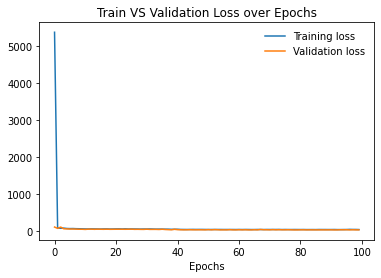

In [ ]:
t = [np.mean(tloss[el]) for el in tloss]
v = [np.mean(vloss[el]) for el in vloss]

plt.plot(t, label='Training loss')
plt.plot(v, label='Validation loss')
plt.title("Train VS Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.legend(frameon=False)